In [51]:
import pandas as pd
from langdetect import detect
import re
import unicodedata


# Load dataset
df = pd.read_csv(path + "/Book Reviews.csv")
df = df.dropna(subset=['Review'])

# --- Language filter ---
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df = df[df['Review'].apply(is_english)].reset_index(drop=True)

# --- Normalize + clean reviews ---
def clean_text(text):

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove emojis and symbols
    text = ''.join(c for c in text if unicodedata.category(c)[0] != "So")

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove non-letter characters except basic punctuation
    text = re.sub(r"[^a-zA-Z0-9.,!?'\s]", ' ', text)

    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['Review'] = df['Review'].astype(str).apply(clean_text)

#Remove duplicate reviews
df = df.drop_duplicates(subset=['Book', 'Review']).reset_index(drop=True)

# Word count for later filtering
df['review_word_count'] = df['Review'].str.split().str.len()


In [52]:
# Optional: check review word count distribution
df['review_word_count'] = df['Review'].str.split().str.len()
print("\n Review word count distribution:")
print(df['review_word_count'].describe())



 Review word count distribution:
count    23047.000000
mean       381.611186
std        416.905109
min          1.000000
25%        115.000000
50%        255.000000
75%        498.000000
max       3730.000000
Name: review_word_count, dtype: float64


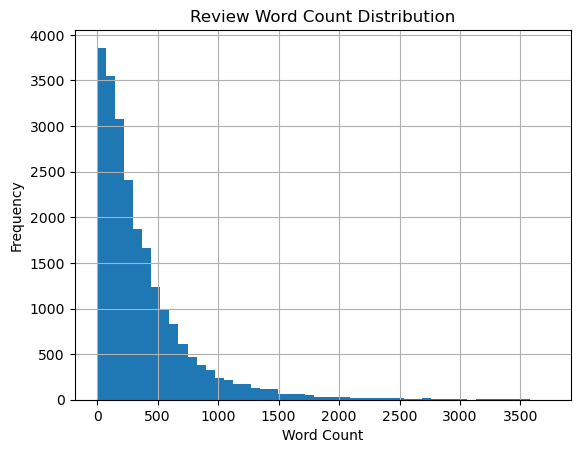

In [53]:
import matplotlib.pyplot as plt

df['review_word_count'].hist(bins=50)
plt.title("Review Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


In [54]:
# Aggregate reviews into a structured, model-friendly format
aggregated_reviews = (
    df
    .groupby('Book')['Review']
    .apply(lambda reviews: '\n'.join([f"Review: {r.strip()}" for r in reviews]))
    .reset_index()
    .rename(columns={'Review': 'Aggregated_Reviews'})
)

# Calculate total word count per book
aggregated_reviews['Total_Word_Count'] = aggregated_reviews['Aggregated_Reviews'].str.split().str.len()


In [55]:
# Filter out books with fewer than 200 total words, to make sure the models dont try to summarize books with little data to make summaries
aggregated_reviews = aggregated_reviews[aggregated_reviews['Total_Word_Count'] >= 200].reset_index(drop=True)

In [56]:
print("\n Preview of aggregated reviews:")
print(aggregated_reviews.head())


 Preview of aggregated reviews:
                    Book                                 Aggregated_Reviews  \
0                  10:04  Review: I m going to let the text of 10 04 by ...   
1                   1984  Review: YOU. ARE. THE. DEAD. Oh my God. I got ...   
2      1Q84 (1Q84, #1-3)  Review: 1Q84 is undoubtedly the biggest litera...   
3  2001: A Space Odyssey  Review: The book is always better than the fil...   
4                   2666  Review: Roberto Bola o's 2666 has been describ...   

   Total_Word_Count  
0              9478  
1              8502  
2             13677  
3             10734  
4             18564  


In [57]:
print("\n Total word count per book (after filtering):")
print(aggregated_reviews['Total_Word_Count'].describe())


 Total word count per book (after filtering):
count     1085.000000
mean      8126.453456
std       4438.843997
min        213.000000
25%       4940.000000
50%       7718.000000
75%      10991.000000
max      32373.000000
Name: Total_Word_Count, dtype: float64


In [58]:
# Here we find the books with word counts in 5 different categories, to make sure the models perform well across a range of review content.
percentiles = [0.01, 0.07, 0.30, 0.65, 0.9999]
targets = aggregated_reviews['Total_Word_Count'].quantile(percentiles)

selected_books = pd.concat([
    aggregated_reviews.iloc[(aggregated_reviews['Total_Word_Count'] - target).abs().argsort().head(1)]
    for target in targets
]).drop_duplicates(subset='Book').reset_index(drop=True)

# Preview selected books
print("\n Books selected for testing:")
print(selected_books[['Book', 'Total_Word_Count']])

print(df.columns)


 Books selected for testing:
                         Book  Total_Word_Count
0                    Cataract               545
1   The Afternoon of a Writer              2099
2               The Monastery              5456
3  The Ravishing of Lol Stein              9470
4               Infinite Jest             32373
Index(['Unnamed: 0', 'Book', 'Review', 'Review Date', 'review_word_count'], dtype='object')


In [59]:
# Books to include that we have read and can manually inspect
books_to_add = [
    'To Kill a Mockingbird', '1984', 'Jane Eyre', 'Animal Farm', 'Crime and Punishment'
]

missing_books = [book for book in books_to_add if book not in selected_books['Book'].values]

additional_books = aggregated_reviews[aggregated_reviews['Book'].isin(missing_books)]

selected_books = pd.concat([selected_books, additional_books], ignore_index=True)

# Preview result
print("\n Final book list for testing:")
print(selected_books[['Book', 'Total_Word_Count']])



 Final book list for testing:
                         Book  Total_Word_Count
0                    Cataract               545
1   The Afternoon of a Writer              2099
2               The Monastery              5456
3  The Ravishing of Lol Stein              9470
4               Infinite Jest             32373
5                        1984              8502
6                 Animal Farm              7712
7        Crime and Punishment             12839
8                   Jane Eyre             14912
9       To Kill a Mockingbird             12178


In [60]:
book_name = 'Infinite Jest'
book_reviews_count = df[df['Book'] == book_name].value_counts().sum()

print(f"\n Number of reviews for '{book_name}': {book_reviews_count}")


 Number of reviews for 'Infinite Jest': 30


In [61]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import re

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

prompt = ()

subset = selected_books  

book_summaries = {}
for i, row in subset.iterrows():
    book = row['Book']
    text = row['Aggregated_Reviews']
    print(f"Summarizing {i+1}/{len(subset)}: {book}")


    words = text.split()
    chunks = [' '.join(words[i:i + 600]) for i in range(0, len(words), 500)]
    chunk_input = ' '.join(chunks[:2])


    input_text = f"{prompt}\n\n{chunk_input}"  # You can omit prompt if needed
    inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)

    output_ids = model.generate(
        **inputs,
        max_length=130,
        min_length=30,
        num_beams=4,
        early_stopping=True
    )

    result = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    book_summaries[book] = result

# Print summaries
for book, summary in book_summaries.items():
    print(f"\nSummary for: {book}")
    print(f"- {summary}")



Summarizing 1/10: Cataract
Summarizing 2/10: The Afternoon of a Writer
Summarizing 3/10: The Monastery
Summarizing 4/10: The Ravishing of Lol Stein
Summarizing 5/10: Infinite Jest
Summarizing 6/10: 1984
Summarizing 7/10: Animal Farm
Summarizing 8/10: Crime and Punishment
Summarizing 9/10: Jane Eyre
Summarizing 10/10: To Kill a Mockingbird

Summary for: Cataract
- Mykhaylo Osadchy's Cataract is world class on the level of the novel as shalamov for the short story. The book proves that we are lucky to live where we live, and to not live under the circumstances that the Soviets lived under.

Summary for: The Afternoon of a Writer
- Handke s narrator suffers from a writer s block and takes a walk around town. A sort of candy of an existional novella. It is about just what the title says. A short, curious meditation on what it is to live one of the many days that a writer may live.

Summary for: The Monastery
- The Monastery is set in Scott s beloved border country, in around 1550. The mona

In [38]:
from bert_score import score

candidates = [book_summaries[book] for book in selected_books['Book']]

references = [selected_books[selected_books['Book'] == book]['Aggregated_Reviews'].values[0]
              for book in selected_books['Book']]

P, R, F1 = score(candidates, references, lang="en", verbose=True)

# Results
print("\n BERTScore Results:")
for i, book in enumerate(selected_books['Book']):
    print(f"{book} — F1: {F1[i].item():.4f}, Precision: {P[i].item():.4f}, Recall: {R[i].item():.4f}")

print(f"\n Average F1: {F1.mean().item():.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 6.59 seconds, 1.52 sentences/sec

 BERTScore Results:
**Cataract** — F1: 0.8338, Precision: 0.8781, Recall: 0.7937
**The Afternoon of a Writer** — F1: 0.8594, Precision: 0.9138, Recall: 0.8110
**The History of the Siege of Lisbon** — F1: 0.8680, Precision: 0.9449, Recall: 0.8026
**Flaubert's Parrot** — F1: 0.8711, Precision: 0.9549, Recall: 0.8008
**Infinite Jest** — F1: 0.8139, Precision: 0.8602, Recall: 0.7723
**1984** — F1: 0.8425, Precision: 0.8825, Recall: 0.8060
**Animal Farm** — F1: 0.8536, Precision: 0.9227, Recall: 0.7941
**Crime and Punishment** — F1: 0.8457, Precision: 0.8995, Recall: 0.7981
**Jane Eyre** — F1: 0.8330, Precision: 0.8710, Recall: 0.7981
**To Kill a Mockingbird** — F1: 0.8958, Precision: 0.9601, Recall: 0.8397

 **Average F1**: 0.8517
